In [1]:
import pandas as pd
import altair as alt
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models import LsiModel, LdaMulticore
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
import string
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from itertools import chain
from fuzzywuzzy import fuzz
from fuzzywuzzy import process 

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## DataSet Imported From DL_DataExploration

In [2]:
df_t4=pd.read_csv('DL_1_Vader_Merge.csv',sep=',')
df_t4.fillna('', inplace=True)
df_t4.head(1)

,Unnamed: 0,Unnamed: 0.1,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,Length of Benefits Review,Length of Side Effects Review,review,Length of Review,review1,review-list,VAD_neg,VAD_neu,VADpos,VAD_compound
0,0,2202,enalapril,4,Highly Effective,Moderate Sideeffects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",184,197,slowed the progression of left ventricular dys...,446,"{'neg': 0.316, 'neu': 0.684, 'pos': 0.0, 'comp...","dict_values([0.316, 0.684, 0.0, -0.9571])",0.316,0.684,0.0,-0.9571


In [3]:
#After Vader Merging , Missing values filled in
df_t4.fillna('', inplace=True)

In [4]:
labelled= pd.read_csv('Labelled_Data .csv', sep=',', header=None)

In [5]:
df_drugsc=pd.read_csv('Final_Drugscom.csv', sep=',')

In [6]:
df_drugsc.head(1)

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,uniqueID,drugName,condition,review,rating,date,usefulCount,review1,review-list,VAD_neg,VAD_neu,VADpos,VAD_compound,Ratings,Ratings_C,Rating_Model
0,0,0,0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"{'neg': 0.136, 'neu': 0.864, 'pos': 0.0, 'comp...","dict_values([0.136, 0.864, 0.0, -0.296])",0.136,0.864,0.0,-0.296,1,Rating>=7,2


# Cleaning Data- Forlmula
    

In [7]:
def preprocess_data(doc_set):
    """
    Input  : Reviews which is a nested list of tweets. 
    
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    
    Output : preprocessed text
    """
    
    
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        #remove punctuation
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        #remove http
        removed_http = [i for i in stripped if not i.startswith('http')]
        #domain-specific words which should be removed
        prefixes = ('rt','cnn','nyt','nbc','time','wsj','who','cdc','stefaniei')
        newlist = [x for x in removed_http if not x.startswith(prefixes)]

        # remove stop words from tokens
        stopped_tokens = [i for i in newlist if not i in en_stop and len(i)>3]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts



### --> Creating Corpi from the reviews

In [8]:
benefit_corpus =[i for i in df_t4['benefitsReview']]
sideeffect_corpus =[i for i in df_t4['sideEffectsReview']]
total_review= [i for i in df_t4['review']]
labelled_corpus= [i for i in labelled[1]]
drugscomreview_corpus =[i for i in df_drugsc['review']]


benefit_tokenized = preprocess_data(benefit_corpus)
sideeffect_tokenized = preprocess_data(sideeffect_corpus)
total_review_tokenized = preprocess_data(total_review)
labelled_tokenized = preprocess_data(labelled_corpus)
drugscomreview_tokenized = preprocess_data(drugscomreview_corpus)


df_t4['benefit_tokenized']= benefit_tokenized 
df_t4['benefit_tokenized']= df_t4['benefit_tokenized'].apply(lambda row: ' '.join(row))
df_t4['sideeffect_tokenized']= sideeffect_tokenized  
df_t4['sideeffect_tokenized']= df_t4['sideeffect_tokenized'].apply(lambda row: ' '.join(row)) 
df_t4['review_tokenized']= total_review_tokenized 
df_t4['review_tokenized']= df_t4['review_tokenized'].apply(lambda row: ' '.join(row)) 
df_drugsc['review_tokenized']= drugscomreview_tokenized
df_drugsc['review_tokenized']= df_drugsc['review_tokenized'].apply(lambda row: ' '.join(row))

label= pd.DataFrame()
label['labelled_tokenized']=labelled_tokenized

label['labelled_tokenized']= label['labelled_tokenized'].apply(lambda row: ' '.join(row)) 




In [9]:
df_t4.head(1)

,Unnamed: 0,Unnamed: 0.1,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,...,Length of Review,review1,review-list,VAD_neg,VAD_neu,VADpos,VAD_compound,benefit_tokenized,sideeffect_tokenized,review_tokenized
0,0,2202,enalapril,4,Highly Effective,Moderate Sideeffects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",...,446,"{'neg': 0.316, 'neu': 0.684, 'pos': 0.0, 'comp...","dict_values([0.316, 0.684, 0.0, -0.9571])",0.316,0.684,0.0,-0.9571,slow progress left ventricular dysfunct overt ...,cough hypotens proteinuria impot renal failur ...,slow progress left ventricular dysfunct overt ...


### Transforming the side effects into new data sets

In [10]:
# What 
replacing= ['No Sideeffects','Moderate Sideeffects', 'High SideEffects']
for i, idx in enumerate(replacing):
    df_t4['sideEffects'].replace(to_replace=idx, value= i, inplace=True)
    
    
replacing= ['Ineffective','Moderate Effect', 'Highly Effective']
for i, idx in enumerate(replacing):
    df_t4['effectiveness'].replace(to_replace=idx, value= i, inplace=True)    
    
rating_rating= [[1,2,3,4], [5,6],[7,8,9,10]]

for i, idx in enumerate(rating_rating):
    df_t4['rating'].replace(to_replace=idx, value = i, inplace=True)    
    

In [11]:
# Inserting the other Data into the frame
list(df_t4['rating'].unique())

[0, 2, 1]

# Model Building 

### Inserting the newly labbeled data and Creating the TRAIN, TEST, SPLITT

###  NOT USED-Another Way of Using Models 

In [12]:
df_drugsc.head() 

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,uniqueID,drugName,condition,review,rating,date,usefulCount,review1,review-list,VAD_neg,VAD_neu,VADpos,VAD_compound,Ratings,Ratings_C,Rating_Model,review_tokenized
0,0,0,0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,"{'neg': 0.136, 'neu': 0.864, 'pos': 0.0, 'comp...","dict_values([0.136, 0.864, 0.0, -0.296])",0.136,0.864,0.000,-0.2960,1,Rating>=7,2,side effect take combin bystol fish
1,1,1,1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,"{'neg': 0.018, 'neu': 0.892, 'pos': 0.09, 'com...","dict_values([0.018, 0.892, 0.09, 0.8603])",0.018,0.892,0.090,0.8603,1,Rating>=7,2,halfway fourth week intuniv becam concern bega...
2,2,2,2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,"{'neg': 0.041, 'neu': 0.876, 'pos': 0.084, 'co...","dict_values([0.041, 0.876, 0.084, 0.7962])",0.041,0.876,0.084,0.7962,0,4 < Rating <7,1,use take anoth oral contracept pill cycl happi...
3,3,3,3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,"{'neg': 0.027, 'neu': 0.879, 'pos': 0.093, 'co...","dict_values([0.027, 0.879, 0.093, 0.7184])",0.027,0.879,0.093,0.7184,1,Rating>=7,2,first use form birth control glad went patch m...
4,4,4,4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,"{'neg': 0.064, 'neu': 0.758, 'pos': 0.178, 'co...","dict_values([0.064, 0.758, 0.178, 0.9403])",0.064,0.758,0.178,0.9403,1,Rating>=7,2,suboxon complet turn life around feel healthie...


###  CSV-Creation After Cleaning of Data - Before Model

In [13]:
#df_t4.to_csv('Colab_drugs.com.csv')



In [14]:
X_list= [df_t4['sideeffect_tokenized'], df_t4['benefit_tokenized'],df_t4['review_tokenized']]
Y_list=[df_t4['sideEffects'], df_t4['effectiveness'], df_t4['rating']]


v = CountVectorizer(analyzer = "word", ngram_range= (1,2))

Classifiers_1 = [
            LogisticRegression(),
            KNeighborsClassifier(3),
            SVC(kernel="rbf"),
            RandomForestClassifier(),
            AdaBoostClassifier(),
]

title=['LogisticRegressio','KNeighborsClassifier','SVC','RandomForestClassifier','AdaBoostClassifier']
results = []
names = []
scoring = 'accuracy'

for X_fact, Y_fact in zip( X_list, Y_list):
    X_train=X_fact
    Y= Y_fact
    X= v.fit_transform(X_train)
    
    for name, model in zip(title,Classifiers_1):
        kfold = KFold(n_splits=5, random_state=42)
        cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        print(len(v.vocabulary_))
 
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
            

36895
LogisticRegressio: 0.746702 (0.009377)
36895
KNeighborsClassifier: 0.553593 (0.034130)
36895
SVC: 0.525575 (0.020667)
36895
RandomForestClassifier: 0.696166 (0.016075)
36895
AdaBoostClassifier: 0.712264 (0.013041)
43005
LogisticRegressio: 0.765365 (0.019568)
43005
KNeighborsClassifier: 0.645988 (0.067616)
43005
SVC: 0.726744 (0.020020)
43005
RandomForestClassifier: 0.749276 (0.016768)
43005
AdaBoostClassifier: 0.741874 (0.014660)
116867
LogisticRegressio: 0.746064 (0.020169)
116867
KNeighborsClassifier: 0.666575 (0.029578)
116867
SVC: 0.685553 (0.017835)
116867
RandomForestClassifier: 0.693604 (0.019406)
116867
AdaBoostClassifier: 0.684267 (0.016061)


###MUSS IN GOOGLE COLAB GEMACHT WERDEN


X_list= df_drugsc['review_tokenized']
Y_list=df_drugsc['Rating_Model']



v = CountVectorizer(analyzer = "word", ngram_range= (1,2))

Classifiers_1 = [
            LogisticRegression(),
            KNeighborsClassifier(3),
            SVC(kernel="rbf"),
            RandomForestClassifier(),
            AdaBoostClassifier(),
]

title=['LogisticRegressio','KNeighborsClassifier','SVC','RandomForestClassifier','AdaBoostClassifier']
results = []
names = []
scoring = 'accuracy'

X= v.fit_transform(X_list)

for name, model in zip(title,Classifiers_1):
    kfold = KFold(n_splits=5, random_state=42)
    cv_results = cross_val_score(model, X, Y_list, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(len(v.vocabulary_))

    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



### CROSS-DATA * DrugLib -> Drugs.com |SideEffects

In [15]:
X_Ltest, Y_Ltest= (label['labelled_tokenized'], labelled[2]) 

listi= [(df_t4['sideeffect_tokenized'], df_t4['sideEffects'])]
Classifiers_1 = [
            LogisticRegression(),
            KNeighborsClassifier(3),
            SVC(kernel="rbf"),
            RandomForestClassifier(),
            AdaBoostClassifier(),
]

title=['LogisticRegressio','KNeighborsClassifier','SVC','RandomForestClassifier','AdaBoostClassifier']        
v = CountVectorizer(analyzer = "word", ngram_range= (1,2))
        
for X_train, y_train in listi:
    InputVectori= [(X_train[0:621], y_train[0:621]),(X_train[621:1242], y_train[621:1242]),(X_train[1242:1863], y_train[1242:1863]),(X_train[1863:2484], y_train[1863:2484]),(X_train[2484:3105], y_train[2484:3105])] 
    
    for name,classifier in zip(title,Classifiers_1):
          
            test=[]
            names.append(name)
            results.append(test)
            for  (X_train, y_train) in InputVectori:
                print('-'*100)

                print('-'*100)

                train_features= v.fit_transform(X_train)

                test_features=v.transform(X_Ltest)
                fit = classifier.fit(train_features,y_train)
                pred = fit.predict(test_features)
                accuracy = accuracy_score(pred,Y_Ltest)
                test.append(accuracy)
                print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))
                print(len(v.vocabulary_))


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Accuracy of LogisticRegressionis 0.35
9487
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Accuracy of LogisticRegressionis 0.355
10018
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Accuracy of LogisticRegressionis 0.3475
8782
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Accuracy of LogisticRegressionis 0.3625
10047
-------------

### CROSS-DATA * DrugLib -> Drugs.com |Overall Rating

In [16]:

X_Ltest, Y_Ltest= (df_drugsc['review_tokenized'],df_drugsc['Rating_Model']) 

listi= [(df_t4['review_tokenized'],df_t4['rating'])]
Classifiers_1 = [
            LogisticRegression(),
            KNeighborsClassifier(3),
            SVC(kernel="rbf"),
            RandomForestClassifier(),
            AdaBoostClassifier(),
]

title=['LogisticRegressio','KNeighborsClassifier','SVC','RandomForestClassifier','AdaBoostClassifier']        
v = CountVectorizer(analyzer = "word", ngram_range= (1,2))
        
for X_train, y_train in listi:
    InputVectori= [(X_train[0:621], y_train[0:621]),(X_train[621:1242], y_train[621:1242]),(X_train[1242:1863], y_train[1242:1863]),(X_train[1863:2484], y_train[1863:2484]),(X_train[2484:3105], y_train[2484:3105])] 
    
    for name,classifier in zip(title,Classifiers_1):
          
            test=[]
            names.append(name)
            results.append(test)
            for  (X_train, y_train) in InputVectori:
                print('-'*100)

                print('-'*100)

                train_features= v.fit_transform(X_train)

                test_features=v.transform(X_Ltest)
                fit = classifier.fit(train_features,y_train)
                pred = fit.predict(test_features)
                accuracy = accuracy_score(pred,Y_Ltest)
                test.append(accuracy)
                print('Accuracy of '+classifier.__class__.__name__+'is '+str(accuracy))
                print(len(v.vocabulary_))


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Accuracy of LogisticRegressionis 0.6675935335448917
31462
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Accuracy of LogisticRegressionis 0.6761535440189032
31917
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Accuracy of LogisticRegressionis 0.6787533432670187
29139
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Accuracy of Logist

### Models Bringing into A DataFrame

In [17]:
len(results)

25

In [18]:
modelling= ['SideEffects','SideEffects','SideEffects','SideEffects','SideEffects',
            'Effectiveness','Effectiveness','Effectiveness','Effectiveness','Effectiveness',
            'Rating','Rating','Rating','Rating','Rating',
           'Drug_Lib on Drug.com: Side-Effects','Drug_Lib on Drug.com: Side-Effects','Drug_Lib on Drug.com: Side-Effects',
            'Drug_Lib on Drug.com: Side-Effects','Drug_Lib on Drug.com: Side-Effects',
            'Drug_Lib on Drug.com: Overall-Rating','Drug_Lib on Drug.com: Overall-Rating','Drug_Lib on Drug.com: Overall-Rating',
            'Drug_Lib on Drug.com: Overall-Rating','Drug_Lib on Drug.com: Overall-Rating'
           ]
df_k_fold= pd.DataFrame({'Model':names,'results':results,'Objects':modelling})

In [19]:
res = pd.DataFrame({'Model': np.repeat(df_k_fold['Model'], df_k_fold['results'].map(len).values),
                    'results': list(chain.from_iterable(df_k_fold['results'])),
                   'Objects':np.repeat(df_k_fold['Objects'], df_k_fold['results'].map(len).values)})

In [20]:
res.head(1)

,Model,results,Objects
0,LogisticRegressio,0.750804,SideEffects


In [21]:
res.to_csv('FINAL_Model')

### Visualization for Models

In [22]:
def whiskers(object):

    base = alt.Chart(res[res['Objects']==object])




    # Define aggregate fields
    lower_box = 'q1(results):Q'
    lower_whisker = 'min(results):Q'
    upper_box = 'q3(results):Q'
    upper_whisker = 'max(results):Q'

    # Compose each layer individually
    lower_plot = base.mark_rule(size=5).encode(
        y=alt.Y(lower_whisker, title="Accuracy"),
        y2=lower_box,
        x='Model:O'
    )

    middle_plot = base.mark_bar(size=50.0).encode(
        y=lower_box,
        y2=upper_box,
        x='Model:O'
    )

    upper_plot = base.mark_rule(size=5).encode(
        y=upper_whisker,
        y2=upper_box,
        x='Model:O'
    )

    middle_tick = base.mark_tick(
        color='white',
        size=1000.0
    ).encode(
        y='median(results):Q',
        x='Model:O',
    )


    return (lower_plot + middle_plot + upper_plot + middle_tick).properties(height=500, width=400, title=('Applied Models on '+object)).interactive()

In [23]:
list(res['Objects'].unique())
    

['SideEffects',
 'Effectiveness',
 'Rating',
 'Drug_Lib on Drug.com: Side-Effects',
 'Drug_Lib on Drug.com: Overall-Rating']

# Visualization for 
#### 1.SideEffects
#### 2.Effectiveness
#### 3.Rating
#### 4.Drug.com:Rating
#### 4.Drug_Lib on Drug.com: Side-Effects
#### 5.Drug_Lib on Drug.com: Overall-Rating 

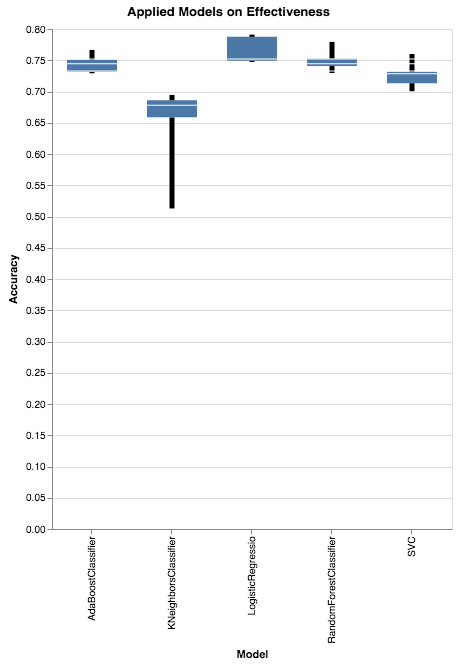

In [24]:
whiskers('Effectiveness')

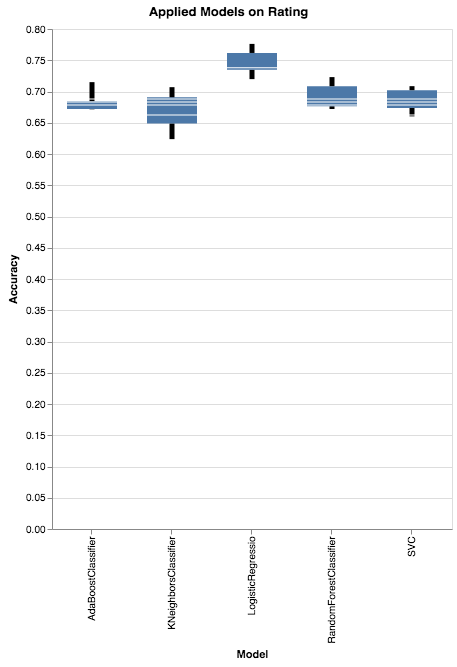

In [25]:
whiskers('Rating')

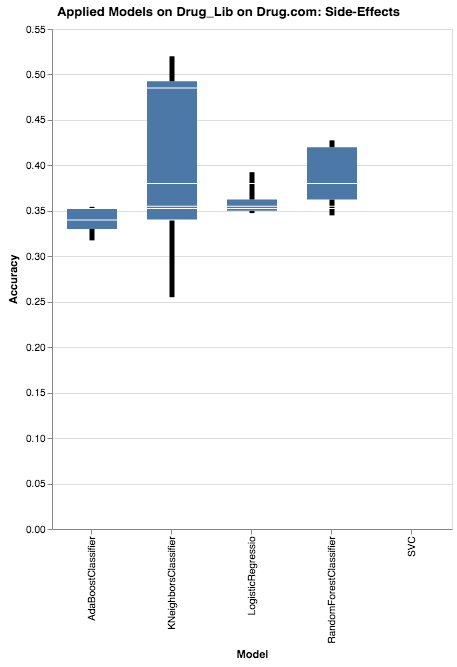

In [26]:
 whiskers('Drug_Lib on Drug.com: Side-Effects')


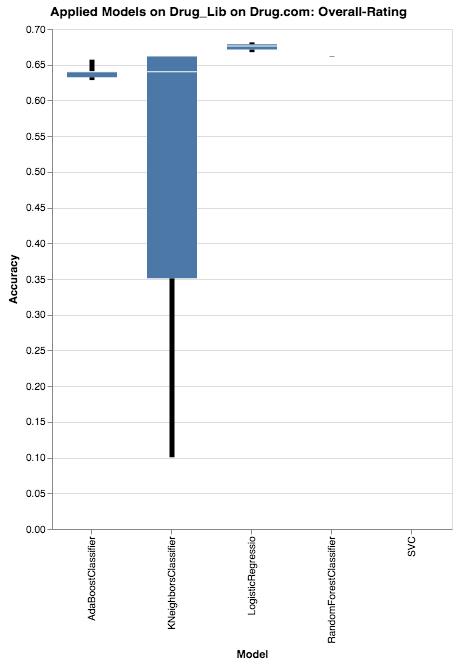

In [27]:
whiskers('Drug_Lib on Drug.com: Overall-Rating')

### Preparing for Drug Recommender

In [ ]:
df_dc= pd.read_csv('Final_Drugscom.csv', sep=',')

total_review_dc= [i for i in df_dc['review']]

total_review_tokenized_dc = preprocess_data(total_review_dc)

df_dc['review_tokenized']= total_review_tokenized_dc 
df_dc['review_tokenized']= df_dc['review_tokenized'].apply(lambda row: ' '.join(row)) 

df_dc.head(1)

### Applying the model on Drug.com for Recommender

X_train_S, y_train_S =df_t4['sideeffect_tokenized'], df_t4['sideEffects']

### Prediction for Drugs.com - SideEffects

X_train_S  =df_t4['sideeffect_tokenized']

y_train_S= df_t4['sideEffects']

X_test_S= df_dc['review_tokenized']



v = CountVectorizer(analyzer = "word", ngram_range= (1,2))
train_features= v.fit_transform(X_train_S)
test_features=v.transform(X_test_S)

m = LogisticRegression()



   



m.fit(train_features,y_train_S)
pred = m.predict(test_features)

df_dc['Pred_SE']=pred

### Prediction for Drugs.com - Effectiveness

X_train_E, y_train_E= df_t4['benefit_tokenized'], df_t4['effectiveness']
X_test_E= df_dc['review_tokenized']

v = CountVectorizer(analyzer = "word", ngram_range= (1,2))
train_features= v.fit_transform(X_train_E)
test_features=v.transform(X_test_E)

m = LogisticRegression()

m.fit(train_features,y_train_E)
pred = m.predict(test_features)


df_dc['Pred_E']=pred

            
 

###Converting to a csv
df_dc.to_csv('Basis_drug_recommender.csv')

df= pd.read_csv('Basis_drug_recommender.csv',sep=',')